In [15]:
from pymoo.operators.crossover.hux import HUX
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.problems.single.knapsack import create_random_knapsack_problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer, Choice, Binary

import numpy as np
from pymoo.core.repair import Repair


import sys
import os
cwd = os.getcwd()
sys.path.append(cwd) 
sys.path.append("/Users/chenzebin/Documents/GitHub/road-planning-for-slums") 
sys.path.append(r"C:\Users\asdbe\OneDrive\Documents\GitHub\road-planning-for-slums") 
import pretreatment.my_graph_helpers as mgh



######################################
### Main code
######################################
jsonPath = (r"C:\Users\asdbe\OneDrive\Documents\GitHub\road-planning-for-slums\JSONInput\punggol_1_withShortcut_withConfigAll_2diagonal_woCross.json") 
myG,myNodeDict,myEdgeDict = mgh.GraphFromJSON_Customized_IgnoreShortCut(jsonPath,scaleTag=True,new_min = 0,new_max = 5)   # 5

###### Initialize info
myG.define_roads_FirstTime()                 # Road
myG.define_interior_parcels()                # Interior_Parcels   ， in this case, it is None

myG.AddShortCutInGraph()

myG.td_dict_init()
myG.feature_init()
myG.td_dict_POI_Related_init()


######################################
### GA
######################################
class MinimizeParcelToPOI(ElementwiseProblem):

    def __init__(self, myG ,numSelection,**kwargs):
        # Define 10 integer variables with bounds (0, 1)
        #vars = {f"y{i}": Integer(bounds=(0, 1)) for i in range(10)}
        #vars = {f"edge{i}": Binary() for i in range(len(myG.shortcutEdges))}

        super().__init__(
                         n_var=len(myG.shortcutEdges),  # 10 variables
                         n_obj=1,
                         n_constr=0,
                         xl=0,  # Lower bound for variables
                         xu=1,  # Upper bound for variables
                         type_var=Integer)  # Type of variables

        self.numShortcutEdges = len(myG.shortcutEdges)
        self.numSelection = numSelection
        self.myG = myG
        self.n_var = self.numShortcutEdges
 

    def _evaluate(self, X,out, *args, **kwargs):

        varList = X.tolist()  # Ensure x is treated as an array
        copyG = self.myG.copy(recalculateTag=False)

      
        edgeMask = self.myG._get_edge_mask()
        
        # edgeMaskShortcut = []
        # for i in range(len(edgeMask)):
        #     thisEdge = self.myG.edge_list[i]
        #     if thisEdge in myG.shortcutEdges:
        #         edgeMaskShortcut.append(edgeMask[i])
    
        info = []
        info_Index = []
        for i in range(self.numShortcutEdges):
            if varList[i] == True:   # and edgeMaskShortcut[i] == 1 
                e = copyG.shortcutEdges[i]
                if not e.isRoad:  # Skip if the edge is already part of the existing road network
                    copyG.add_road_segment(e)
                    
                    for node in e.nodes:
                        info.append(node.x)
                        info.append(node.y)
                            
                    info_Index.append(i)
                    
                    # ### Update Mask
                    # edgeMask = self.myG._get_edge_mask()
                    # edgeMaskShortcut = []
                    # for j in range(len(edgeMask)):
                    #     thisEdge = self.myG.edge_list[j]
                    #     if thisEdge in myG.shortcutEdges:
                    #         edgeMaskShortcut.append([edgeMask[j]])

        # print (info)
        # print (info_Index)
 
        # Initial feature and property
        copyG.td_dict_init()
        copyG.feature_init()
        copyG.td_dict_POI_Related_init()

        
        #print (copyG.f2POI_avg)
        out["F"] = copyG.f2POI_avg

        
        
class ConsiderMaximumSelection(Repair):

    def _do(self, problem, Z, **kwargs):

        # maximum capacity for the problem
        Q = problem.numSelection
        
        
        # the corresponding weight of each individual
        # weights = (Z * problem.W).sum(axis=1)
        # print (problem.W)
 
        w = np.ones(problem.n_var)
        weights = (Z * w).sum(axis=1)
        # now repair each indvidiual i
        for i in range(len(Z)):

            # the packing plan for i
            z = Z[i]

            # while the maximum capacity violation holds
            while weights[i] > Q:

                # randomly select an item currently picked
                item_to_remove = np.random.choice(np.where(z)[0])

                # and remove it
                z[item_to_remove] = False

                # adjust the weight
                weights[i] -= 1

        return Z


# info = []
# for e in myG.road_edges:
#     for node in e.nodes:
#         info.append(node.x)
#         info.append(node.y)

# print (info)

class MyCallback:
    def __init__(self):
        self.data = []
    
    def __call__(self, algorithm):
        gen = algorithm.n_gen
        opt = algorithm.pop.get("F").min()
        avg = algorithm.pop.get("F").mean()
        self.data.append((gen, opt, avg))


callback = MyCallback()

problem = MinimizeParcelToPOI(myG,10)
algorithm = GA(pop_size=100,
               sampling=BinaryRandomSampling(),
               crossover=HUX(),
               mutation=BitflipMutation(),
               repair=ConsiderMaximumSelection(),
               eliminate_duplicates=True,
               )

res = minimize(problem,
               algorithm,
               termination=('n_gen', 20),
               seed=1,
               verbose=True,
               callback=callback)




n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      100 |  1.0674972468 |  1.0386823838
     2 |      200 |  1.0597578542 |  1.0386823838
     3 |      300 |  1.0527369928 |  1.0374185745
     4 |      400 |  1.0473624207 |  1.0374185745
     5 |      500 |  1.0441704182 |  1.0374185745


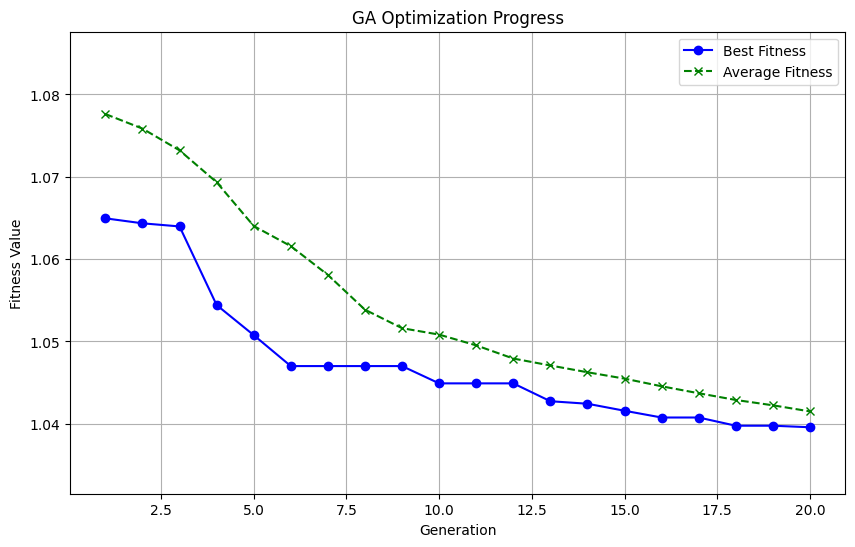

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [7]:
import matplotlib.pyplot as plt

# Assuming `callback` has the collected data
generations = [entry[0] for entry in callback.data]
best_fitness = [entry[1] for entry in callback.data]
avg_fitness = [entry[2] for entry in callback.data]

plt.figure(figsize=(10, 6))
plt.plot(generations, best_fitness, label='Best Fitness', color='blue', marker='o')
plt.plot(generations, avg_fitness, label='Average Fitness', color='green', linestyle='--', marker='x')

# Set Y-axis limit from 0 to 0.12
# Adjust the Y-axis limit based on the values you have
plt.ylim(min(avg_fitness) - 0.01, max(avg_fitness) + 0.01)

plt.title('GA Optimization Progress')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.legend()
plt.grid(True)
plt.show()




result = []
for item in res.X:
    if item == False:
        result.append(0)
    elif item == True:
        result.append(1)

print (result)